In [1]:
# Required packages for processing
import os
import pandas as pd
import numpy as np
import pytz, time
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
from pandarallel import pandarallel
import seaborn as sns
from datetime import datetime
from matplotlib.ticker import MultipleLocator, FixedLocator, LogLocator, NullFormatter, ScalarFormatter

%matplotlib inline

In [2]:
def preprocess_parquet_to_df(name):
    location_dataset = "path/to/surf-dataset/"
    df = pd.read_parquet(os.path.join(location_dataset, name))
    df = df.replace(-1, 0)
    df = df.fillna(0)
    df["dt"] = pd.to_datetime(df.index, utc=True, unit="s")
    df["dt"] = df["dt"].dt.tz_convert(pytz.timezone('Europe/Amsterdam')).dt.tz_localize(None)
    df = df.set_index("dt")
    df = df.sort_index()
    df['Total']= df.sum(axis=1)
    return(df)

def preprocess_jobdata_to_df(name):
    location_job_data_csv = "path/to/surfsara-jobdata/"
    with open(os.path.join(location_job_data_csv, name),'r') as file:
        filedata = file.read()
        filedata = filedata.replace('None assigned','NoneAssigned')
    with open(os.path.join(location_job_data_csv, str('processed_'+name)),'w') as file:
        file.write(filedata)
    jobdata = pd.read_fwf(os.path.join(location_job_data_csv, str('processed_'+name)), delimiter=r"\s+", header=None)#, low_memory=False)
    jobdata = jobdata.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    jobdata = jobdata.rename(columns=jobdata.iloc[0]).drop(jobdata.index[0])
    jobdata = jobdata.iloc[1:]
    jobdata = jobdata.astype({"ElapsedRaw": int, "CPUTimeRAW": int, "NCPUS": int})
    return(jobdata)

def split_nodes(s):
    if s is None or len(s) == 0:
        return set()
    
    s = s.replace("\r\n", "").replace("\n", "").replace("\t", "")

    start = 0
    index = 0
    rack_chunks = []
    in_bracket = False
    while index < len(s):  # Separate them in parts like r12n[1-30,32] or r13n1
        if s[index] == "[":
            in_bracket = True
        elif s[index] == "]":
            in_bracket = False
        elif s[index] == "," and not in_bracket:
            rack_chunks.append(s[start: index])
            start = index + 1
        index += 1
    rack_chunks.append(s[start: index])  # Add the last line
    
    node_names = set()

    for rack_chunk in rack_chunks:
        if "[" in rack_chunk:
            prefix, postfix = rack_chunk.split("[")
            postfix = postfix[:-1]  # Remove the last bracket
            nodes = postfix.split(",")
            for node in nodes:
                if "-" in node:
                    start, end = node.split("-")
                    if not start.isnumeric() or not end.isnumeric():
                        #print("???", s)
                        continue
                    for i in range(int(start), int(end) + 1):
                        node_names.add("{}{}".format(prefix, i))
                else:
                    node_names.add("{}{}".format(prefix, node))
        else:
            node_names.add(rack_chunk)

    return node_names

def calculate_perjob(row, data_type):
    start = row["Start"]
    end = row["End"]
    nodes = row["NodeList"]
    selection = data_type.loc[start:end]

    splitnodes = split_nodes(nodes)
    intersection_nodes = set(selection.columns).intersection(splitnodes)

    return selection[intersection_nodes].sum().sum()  # First is per column, second is summing the series

In [3]:
# Load and preprocess data
node_sockstat_TCP_mem = preprocess_parquet_to_df("node_sockstat_TCP_mem")
node_sockstat_UDP_mem = preprocess_parquet_to_df("node_sockstat_UDP_mem")
node_network_transmit_packets = preprocess_parquet_to_df("node_network_transmit_packets")
jobdata = preprocess_jobdata_to_df("jobdata.csv")

In [4]:
# Check if preprocessing was executed as expected
filtered_jobdata = jobdata[(jobdata["Start"] >= '2019-12-29 23:00:00') & (jobdata["Start"] <= '2020-08-07 21:59:45')]
filtered_jobdata = filtered_jobdata[(~filtered_jobdata["NodeList"].str.contains("None")) & (~filtered_jobdata["NodeList"].str.contains("software")) & (~filtered_jobdata["NodeList"].str.contains("login"))]
filtered_jobdata["ElapsedRaw"] = filtered_jobdata["ElapsedRaw"]

In [ ]:
filtered_jobdata.to_pickle("filtered_jobdata.pkl")

In [6]:
if not os.path.exists("/cache/node_sockstat_TCP_mem_perjob.csv"):
    pandarallel.initialize(nb_workers=min(cpu_count(), 8), progress_bar=True)
    node_sockstat_TCP_mem_perjob = filtered_jobdata
    node_sockstat_TCP_mem_perjob["node_sockstat_TCP_mem"] =  node_sockstat_TCP_mem_perjob.parallel_apply(calculate_perjob, axis=1, data_type=node_sockstat_TCP_mem)
    node_sockstat_TCP_mem_perjob.to_csv('./cache/node_sockstat_TCP_mem_perjob.csv')


INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
if not os.path.exists("/cache/node_sockstat_UDP_mem_perjob.csv"):
    pandarallel.initialize(nb_workers=min(cpu_count(), 8), progress_bar=True)
    node_sockstat_UDP_mem_perjob = filtered_jobdata  # If cell above is executed, it will be essentially be node_sockstat_TCP_mem_perjob etc.
    node_sockstat_UDP_mem_perjob["node_sockstat_UDP_mem"] = node_sockstat_UDP_mem_perjob.parallel_apply(calculate_perjob, axis=1, data_type=node_sockstat_UDP_mem)
    node_sockstat_UDP_mem_perjob.to_csv('./cache/node_sockstat_UDP_mem_perjob.csv')

In [8]:
if not os.path.exists("/cache/node_network_transmit_packets_perjob.csv"):
    pandarallel.initialize(nb_workers=min(cpu_count(), 10), progress_bar=True)
    node_network_transmit_packets_perjob = filtered_jobdata
    node_network_transmit_packets_perjob["node_network_transmit_packets"] = node_network_transmit_packets_perjob.parallel_apply(calculate_perjob, axis=1, data_type=node_network_transmit_packets)
    node_network_transmit_packets_perjob.to_csv('./cache/node_network_transmit_packets_perjob.csv')

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
# Exclude 0 values, since in this instance we only want to analyze jobs with traffic
node_sockstat_TCP_mem_perjob = pd.read_csv('./cache/node_sockstat_TCP_mem_perjob.csv')  
node_sockstat_TCP_mem_perjob = node_sockstat_TCP_mem_perjob[(node_sockstat_TCP_mem_perjob["node_sockstat_TCP_mem"] > 0)]
# Transform runtime to hours
node_sockstat_TCP_mem_perjob["ElapsedRaw"] = node_sockstat_TCP_mem_perjob["ElapsedRaw"] * 60  # Back to minutes

In [5]:
# Calculate averages for different time bins
average_5min_TCP = (np.mean(node_sockstat_TCP_mem_perjob.loc[node_sockstat_TCP_mem_perjob["ElapsedRaw"] < 5, "node_sockstat_TCP_mem"]))
average_1hr_TCP = (np.mean(node_sockstat_TCP_mem_perjob.loc[(node_sockstat_TCP_mem_perjob["ElapsedRaw"] >= 5) & (node_sockstat_TCP_mem_perjob["ElapsedRaw"] < 60), "node_sockstat_TCP_mem"]))
average_6hrs_TCP = (np.mean(node_sockstat_TCP_mem_perjob.loc[(node_sockstat_TCP_mem_perjob["ElapsedRaw"] >= 60) & (node_sockstat_TCP_mem_perjob["ElapsedRaw"] < 360), "node_sockstat_TCP_mem"]))
average_1day_TCP = (np.mean(node_sockstat_TCP_mem_perjob.loc[(node_sockstat_TCP_mem_perjob["ElapsedRaw"] >= 360) & (node_sockstat_TCP_mem_perjob["ElapsedRaw"] < 1440), "node_sockstat_TCP_mem"]))
average_1to5days_TCP = (np.mean(node_sockstat_TCP_mem_perjob.loc[(node_sockstat_TCP_mem_perjob["ElapsedRaw"] >= 1440), "node_sockstat_TCP_mem"]))
print("mean_5min",average_5min_TCP)
print("mean_1hr",average_1hr_TCP)
print("mean_6hrs",average_6hrs_TCP)
print("mean_1day",average_1day_TCP)
print("mean_1to5days",average_1to5days_TCP)

mean_5min 96.32621363615068
mean_1hr 4769.480238931925
mean_6hrs 49707.708872564675
mean_1day 133187.728128707
mean_1to5days 2034087.5957803885


<ipython-input-6-ca4e7cdd28e7>:7: UserWarning: Attempting to set identical bottom == top == 1 results in singular transformations; automatically expanding.
  plt.ylim(bottom=1)


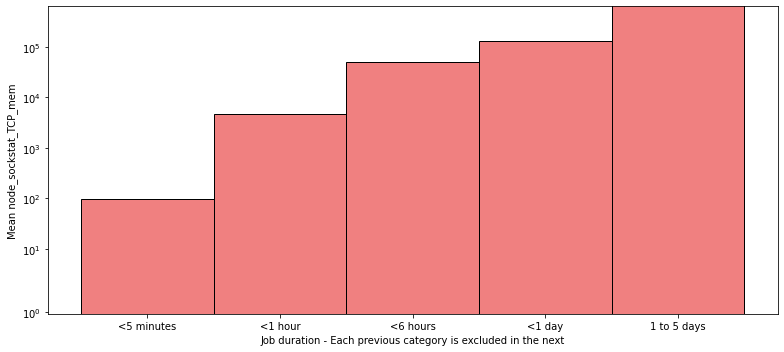

In [6]:
# Visualize results
cat = ['<5 minutes', '<1 hour', '<6 hours', '<1 day', '1 to 5 days']
vals = [average_5min_TCP, average_1hr_TCP, average_6hrs_TCP, average_1day_TCP, average_1to5days_TCP]

fig = plt.figure(figsize=(11, 5))
plt.yscale("symlog")
plt.ylim(bottom=1)
plt.ylim(top=10**5.8)
plt.locator_params(axis='y', numticks=12)
plt.bar(cat, vals, width=1, edgecolor="black", color="lightcoral")
plt.xlabel("Job duration - Each previous category is excluded in the next")
plt.ylabel("Mean node_sockstat_TCP_mem")
plt.tight_layout()
fig.savefig("TCP_mem_job_duration.pdf")

In [ ]:
# Exclude 0 values, since in this instance we only want to analyze jobs with traffic
node_sockstat_UDP_mem_perjob = pd.read_csv('./cache/node_sockstat_UDP_mem_perjob.csv')  
node_sockstat_UDP_mem_perjob = node_sockstat_UDP_mem_perjob[(node_sockstat_UDP_mem_perjob["node_sockstat_UDP_mem"] > 0)]
# Transform runtime to hours
node_sockstat_UDP_mem_perjob["ElapsedRaw"] = node_sockstat_UDP_mem_perjob["ElapsedRaw"] * 60  # Back to minutes

In [8]:
# Calculate averages for different time bins
average_5min_UDP = (np.mean(node_sockstat_UDP_mem_perjob.loc[node_sockstat_UDP_mem_perjob["ElapsedRaw"] < 5, "node_sockstat_UDP_mem"]))
average_1hr_UDP = (np.mean(node_sockstat_UDP_mem_perjob.loc[(node_sockstat_UDP_mem_perjob["ElapsedRaw"] >= 5) & (node_sockstat_UDP_mem_perjob["ElapsedRaw"] < 60), "node_sockstat_UDP_mem"]))
average_6hrs_UDP = (np.mean(node_sockstat_UDP_mem_perjob.loc[(node_sockstat_UDP_mem_perjob["ElapsedRaw"] >= 60) & (node_sockstat_UDP_mem_perjob["ElapsedRaw"] < 360), "node_sockstat_UDP_mem"]))
average_1day_UDP = (np.mean(node_sockstat_UDP_mem_perjob.loc[(node_sockstat_UDP_mem_perjob["ElapsedRaw"] >= 360) & (node_sockstat_UDP_mem_perjob["ElapsedRaw"] < 1440), "node_sockstat_UDP_mem"]))
average_1to5days_UDP = (np.mean(node_sockstat_UDP_mem_perjob.loc[(node_sockstat_UDP_mem_perjob["ElapsedRaw"] >= 1440), "node_sockstat_UDP_mem"]))
print("mean_5min",average_5min_UDP)
print("mean_1hr",average_1hr_UDP)
print("mean_6hrs",average_6hrs_UDP)
print("mean_1day",average_1day_UDP)
print("mean_1to5days",average_1to5days_UDP)

mean_5min 673.0314142300242
mean_1hr 14003.964082551885
mean_6hrs 107392.76522516768
mean_1day 484650.8459741993
mean_1to5days 3092752.448493567


<ipython-input-9-680db6a99ee0>:7: UserWarning: Attempting to set identical bottom == top == 1 results in singular transformations; automatically expanding.
  plt.ylim(bottom=1)


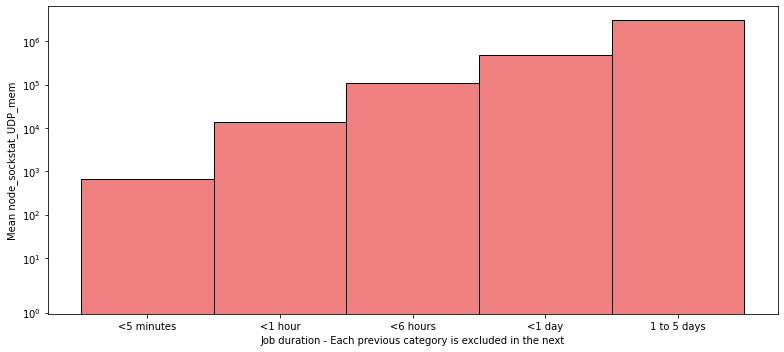

In [9]:
# Visualize results
cat = ['<5 minutes', '<1 hour', '<6 hours', '<1 day', '1 to 5 days']
vals = [average_5min_UDP, average_1hr_UDP, average_6hrs_UDP, average_1day_UDP, average_1to5days_UDP]

fig = plt.figure(figsize=(11, 5))
plt.yscale("symlog")
plt.ylim(bottom=1)
plt.ylim(top=10**6.8)
plt.locator_params(axis='y', numticks=12)
plt.bar(cat, vals, width=1, edgecolor="black", color="lightcoral")
plt.xlabel("Job duration - Each previous category is excluded in the next")
plt.ylabel("Mean node_sockstat_UDP_mem")
plt.tight_layout()
fig.savefig("UDP_mem_job_duration.pdf")

In [ ]:
# Exclude 0 values, since in this instance we only want to analyze jobs with traffic
node_network_transmit_packets_perjob = pd.read_csv('./cache/node_network_transmit_packets_perjob.csv')  
node_network_transmit_packets_perjob = node_network_transmit_packets_perjob[(node_network_transmit_packets_perjob["node_network_transmit_packets"] > 0)]
# Transform runtime to hours
node_network_transmit_packets_perjob["ElapsedRaw"] = node_network_transmit_packets_perjob["ElapsedRaw"] / 3600  # Back to minutes

In [11]:
# Calculate averages for different time bins
average_5min_transmit = (np.mean(node_network_transmit_packets_perjob.loc[node_network_transmit_packets_perjob["ElapsedRaw"] < 5, "node_network_transmit_packets"]))
average_1hr_transmit = (np.mean(node_network_transmit_packets_perjob.loc[(node_network_transmit_packets_perjob["ElapsedRaw"] >= 5) & (node_network_transmit_packets_perjob["ElapsedRaw"] < 60), "node_network_transmit_packets"]))
average_6hrs_transmit = (np.mean(node_network_transmit_packets_perjob.loc[(node_network_transmit_packets_perjob["ElapsedRaw"] >= 60) & (node_network_transmit_packets_perjob["ElapsedRaw"] < 360), "node_network_transmit_packets"]))
average_1day_transmit = (np.mean(node_network_transmit_packets_perjob.loc[(node_network_transmit_packets_perjob["ElapsedRaw"] >= 360) & (node_network_transmit_packets_perjob["ElapsedRaw"] < 1440), "node_network_transmit_packets"]))
average_1to5days_transmit = (np.mean(node_network_transmit_packets_perjob.loc[(node_network_transmit_packets_perjob["ElapsedRaw"] >= 1440), "node_network_transmit_packets"]))
print("mean_5min",average_5min_transmit)
print("mean_1hr",average_1hr_transmit)
print("mean_6hrs",average_6hrs_transmit)
print("mean_1day",average_1day_transmit)
print("mean_1to5days",average_1to5days_transmit)

mean_5min 15400013744.566414
mean_1hr 532543409387.8179
mean_6hrs 3367186471092.3037
mean_1day 16417011785666.332
mean_1to5days 82785903601585.69


<ipython-input-12-56e58ad3f512>:7: UserWarning: Attempting to set identical bottom == top == 1 results in singular transformations; automatically expanding.
  plt.ylim(bottom=1)


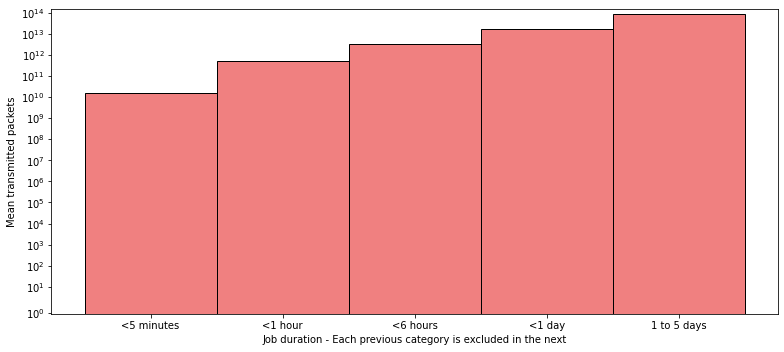

In [12]:
# Visualize results
cat = ['<5 minutes', '<1 hour', '<6 hours', '<1 day', '1 to 5 days']
vals = [average_5min_transmit, average_1hr_transmit, average_6hrs_transmit, average_1day_transmit, average_1to5days_transmit]

fig = plt.figure(figsize=(11, 5))
plt.yscale("symlog")
plt.ylim(bottom=1)
plt.ylim(top=10**14.2)
plt.locator_params(axis='y', numticks=12)
plt.bar(cat, vals, width=1, edgecolor="black", color="lightcoral")
plt.xlabel("Job duration - Each previous category is excluded in the next")
plt.ylabel("Mean transmitted packets")
plt.tight_layout()
fig.savefig("node_network_transmit_packets_job_duration.pdf")

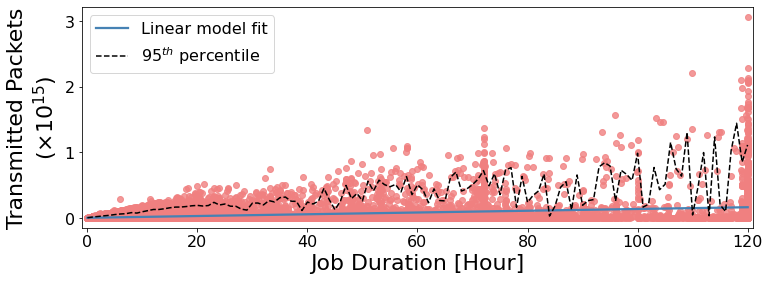

In [3]:
# Generate scatterplot
plot_df = node_network_transmit_packets_perjob.copy()
fig, ax = plt.subplots(figsize=(11, 4))
ax.set_xlim(-1, 121)
sns.regplot(x="ElapsedRaw", y="node_network_transmit_packets", 
            data=plot_df, 
            scatter=True,
            fit_reg=True,
            ax=ax,
            marker='o',
            color="lightcoral",
            line_kws={"color": "steelblue", "label": "Linear model fit"},
            scatter_kws={"rasterized": True})

plot_df['ElapsedRaw'] = plot_df['ElapsedRaw'].astype(np.int)
p95_data = plot_df.groupby("ElapsedRaw")['node_network_transmit_packets'].quantile(.95)
ax.plot(p95_data.index, p95_data, color="black", linestyle="dashed", label="$95^{th}$ percentile")

ax.get_yaxis().set_major_formatter(ScalarFormatter(useMathText=True))
ax.yaxis.get_offset_text().set_visible(False)
fig.tight_layout()

ax.set_xlabel("Job Duration [Hour]", fontsize=22)
ax.set_ylabel("Transmitted Packets\n({})".format(ax.get_yaxis().get_major_formatter().get_offset()), fontsize=22)  # Based on https://stackoverflow.com/a/45766598

ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.get_yaxis().get_offset_text().set_size(14)

ax.legend(prop={"size": 16}, loc="upper left")
fig.tight_layout()

date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig.savefig(f"node_network_transmit_packets_job_scatter_{date_time}.pdf", bbox_inches = "tight")
